In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/e-commerce-shoppers-behaviour-understanding/test_data_v2.csv
/kaggle/input/e-commerce-shoppers-behaviour-understanding/train_data_v2.csv
/kaggle/input/e-commerce-shoppers-behaviour-understanding/sample.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/e-commerce-shoppers-behaviour-understanding/train_data_v2.csv')
train_df

,HomePage,HomePage_Duration,LandingPage,LandingPage_Duration,ProductDescriptionPage,ProductDescriptionPage_Duration,GoogleMetric:Bounce Rates,GoogleMetric:Exit Rates,GoogleMetric:Page Values,SeasonalPurchase,...,SearchEngine,Zone,Type of Traffic,CustomerType,Gender,Cookies Setting,Education,Marital Status,WeekendPurchase,Made_Purchase
0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.0,0.0,...,1.0,9.0,3.0,Returning_Visitor,Not Specified,Deny,Not Specified,Other,0.0,False
1,0.0,0.000000,0.0,0.0,2.0,2.666667,0.050000,0.140000,0.0,0.0,...,2.0,2.0,4.0,Returning_Visitor,Female,Deny,Others,Married,0.0,False
2,0.0,0.000000,0.0,0.0,10.0,627.500000,0.020000,0.050000,0.0,0.0,...,3.0,1.0,4.0,Returning_Visitor,Female,ALL,Others,Married,1.0,False
3,0.0,0.000000,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.0,0.4,...,4.0,3.0,3.0,Returning_Visitor,Male,ALL,Diploma,Single,0.0,False
4,1.0,0.000000,0.0,0.0,0.0,0.000000,0.200000,0.200000,0.0,0.0,...,2.0,1.0,5.0,Returning_Visitor,Male,Deny,Diploma,Other,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14726,1.0,4.000000,0.0,0.0,39.0,983.138889,0.015385,0.017599,0.0,0.0,...,2.0,6.0,3.0,Returning_Visitor,Female,Deny,NaN,Married,0.0,True
14727,8.0,117.023809,2.0,57.0,11.0,252.892857,0.000000,0.011078,0.0,0.0,...,2.0,2.0,4.0,Returning_Visitor,Not Specified,ALL,Diploma,Married,0.0,True
14728,2.0,75.600000,2.0,652.8,10.0,1143.666667,0.000000,0.023333,0.0,0.0,...,2.0,4.0,2.0,Returning_Visitor,Not Specified,Required,Others,Single,0.0,True
14729,0.0,0.000000,0.0,0.0,6.0,1057.000000,0.000000,0.033333,0.0,0.0,...,4.0,4.0,1.0,Returning_Visitor,Not Specified,Required,Not Specified,Married,0.0,True


In [3]:
test_df = pd.read_csv('/kaggle/input/e-commerce-shoppers-behaviour-understanding/test_data_v2.csv')
test_df.head()

,HomePage,HomePage_Duration,LandingPage,LandingPage_Duration,ProductDescriptionPage,ProductDescriptionPage_Duration,GoogleMetric:Bounce Rates,GoogleMetric:Exit Rates,GoogleMetric:Page Values,SeasonalPurchase,...,OS,SearchEngine,Zone,Type of Traffic,CustomerType,Gender,Cookies Setting,Education,Marital Status,WeekendPurchase
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.0,0.0,...,1.0,1.0,1.0,1.0,Returning_Visitor,Not Specified,Deny,Not Specified,Single,0.0
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.000000,0.100000,0.0,0.0,...,2.0,2.0,1.0,2.0,Returning_Visitor,Not Specified,ALL,Graduate,Married,0.0
2,0.0,0.0,0.0,0.0,19.0,154.216667,0.015789,0.024561,0.0,0.0,...,2.0,2.0,1.0,3.0,Returning_Visitor,Female,Required,Diploma,Other,0.0
3,0.0,0.0,0.0,0.0,2.0,37.000000,0.000000,0.100000,0.0,0.8,...,2.0,2.0,2.0,3.0,Returning_Visitor,Not Specified,Required,Graduate,Other,0.0
4,0.0,0.0,0.0,0.0,16.0,407.750000,0.018750,0.025833,0.0,0.4,...,1.0,1.0,4.0,3.0,Returning_Visitor,Female,Deny,Others,Other,0.0


In [4]:
# Data
# Preprocessing / Data Cleaning
# Base Model
# Model Selection
# Best Model
# Submit

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14731 entries, 0 to 14730
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   HomePage                         14578 non-null  float64
 1   HomePage_Duration                14581 non-null  float64
 2   LandingPage                      14578 non-null  float64
 3   LandingPage_Duration             14596 non-null  float64
 4   ProductDescriptionPage           14608 non-null  float64
 5   ProductDescriptionPage_Duration  14564 non-null  float64
 6   GoogleMetric:Bounce Rates        14580 non-null  float64
 7   GoogleMetric:Exit Rates          14602 non-null  float64
 8   GoogleMetric:Page Values         14599 non-null  float64
 9   SeasonalPurchase                 14581 non-null  float64
 10  Month_SeasonalPurchase           14587 non-null  object 
 11  OS                               14597 non-null  float64
 12  SearchEngine      

In [6]:
num_vars = ["HomePage", "HomePage_Duration", "LandingPage", "LandingPage_Duration", "ProductDescriptionPage", "ProductDescriptionPage_Duration", "GoogleMetric:Bounce Rates", "GoogleMetric:Exit Rates", "GoogleMetric:Page Values", "SeasonalPurchase"]
cat_vars = ["Month_SeasonalPurchase", "CustomerType", "Gender","Cookies Setting", "Education","Marital Status"]

In [7]:
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, PowerTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE

In [8]:
y_train = train_df['Made_Purchase']
X_train = train_df.drop(columns=['Made_Purchase'])

In [9]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),("scaler", FunctionTransformer(np.log1p))]
)

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OneHotEncoder(handle_unknown="ignore", sparse=False))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_vars),
        ("cat", categorical_transformer, cat_vars),
    ]
)

In [10]:
X_train = preprocessor.fit_transform(X_train)

In [11]:
# #evaluation - baselines
# num_folds = 10
# seed = 7
# scoring = 'accuracy'
# models = []
# models.append(('LR', LogisticRegression(max_iter=1000)))
# models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# models.append(('SVC', SVC(gamma="auto")))

# results = []
# names = []
# for name, model in models:
#     kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
#     cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s %f %f " % (name, cv_results.mean(), cv_results.std())
#     print(msg)

In [12]:
# model = SGDClassifier(max_iter=1000, eta0=1)
# loss = ['modified_huber', 'squared_hinge']
# learning_rate = ['optimal', 'adaptive']
# alpha = [0.1]
# warm_start = [True]
# penalty = ['l2']
# # define grid search
# grid = dict(loss=loss,learning_rate=learning_rate,alpha=alpha,warm_start=warm_start, penalty=penalty)
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [13]:
clf = SGDClassifier(loss='modified_huber', learning_rate='adaptive', alpha=0.1, eta0=1, penalty='l2', warm_start=True)
# clf = RFE(estimator, n_features_to_select=5, step=1)

In [14]:
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.1, eta0=1, learning_rate='adaptive',
              loss='modified_huber', warm_start=True)

In [15]:
clf.score(X_train, y_train)

0.6664177584685358

In [16]:
from sklearn.model_selection import cross_val_score

cvs = cross_val_score(clf, X_train, y_train)
cvs.mean()

0.5548957124635245

In [17]:
y_pred = clf.predict(X_train)

In [18]:
from sklearn.metrics import f1_score

f1_score(y_train, y_pred)

0.39333333333333337

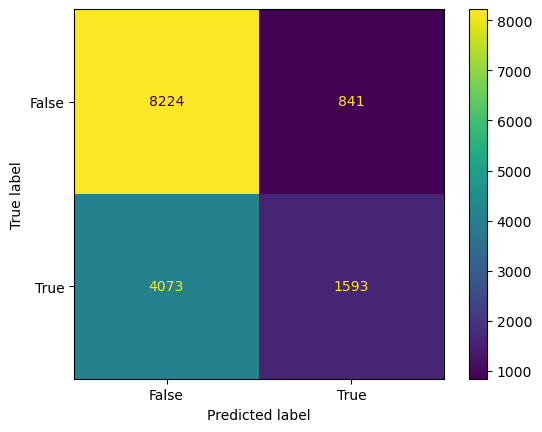

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_train, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [20]:
X_test = preprocessor.fit_transform(test_df)

In [21]:
prediction = clf.predict(X_test)
prediction

array([False, False, False, ..., False, False, False])

In [22]:
submission = pd.DataFrame(columns = ['id', 'Made_Purchase'])
submission['id'] = [i for i in range(len(prediction))]
submission['Made_Purchase'] = prediction

submission.to_csv('submission.csv', index=False)

In [23]:
submission.head()

,id,Made_Purchase
0,0,False
1,1,False
2,2,False
3,3,False
4,4,False
